In [1]:
import pandas as pd
import numpy as np

In [2]:
dfo = pd.read_csv('../../../Lectures/Lecture 3/data/hw3.csv')
dfo.set_index('ts', inplace=True)
dfo.head()

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-02 14:00:00,22.4150,22.4913,22.0816,22.3516,31502.151631,NaN,UNI,ETH
2021-12-02 23:00:00,4.8043,4.8043,4.7426,4.7806,73686.230000,NaN,CRV,ETH
2021-12-10 15:00:00,182.4900,NaN,175.2100,175.8600,73736.747000,NaN,SOL,SOL
2021-12-10 18:00:00,3978.4300,3989.7400,3932.0000,3972.3400,18508.040102,NaN,ETH,ETH
2021-12-08 21:00:00,193.3240,194.2420,192.5640,193.1540,69426.909000,NaN,SOL,SOL


In [3]:
#check if there is nan, inf for close and volume, which will be used for calculating volumeUSD
print(np.isnan(dfo.close).any())
print(np.isnan(dfo.volume).any())
print(np.isinf(dfo.close).any())
print(np.isinf(dfo.volume).any())

True
False
False
False


In [4]:
#take a look at token
dfo.token.value_counts()

BTC                                   323
COMP                                  322
CRV                                   318
SOL                                   318
USDT                                  314
UNI                                   312
AAVE                                  312
ETH                                   298
<span name="tokenName">UNI</span>      30
<span name="tokenName">ETH</span>      28
<span name="tokenName">USDT</span>     19
<span name="tokenName">CRV</span>      17
<span name="tokenName">SOL</span>      16
<span name="tokenName">AAVE</span>     16
<span name="tokenName">BTC</span>      14
<span name="tokenName">COMP</span>     10
Name: token, dtype: int64

In [5]:
#take a look at chain
dfo.chain.value_counts()

ETH     1663
BTC      337
SOL      334
USDT     333
Name: chain, dtype: int64

In [6]:
#clean token format
df = dfo.sort_index(ascending=True)
df['token'] = df['token'].str.replace('<span name="tokenName">' , '')
df['token'] = df['token'].str.replace('</span>', '')
df.token.value_counts()

UNI     342
BTC     337
CRV     335
SOL     334
USDT    333
COMP    332
AAVE    328
ETH     326
Name: token, dtype: int64

In [7]:
#noticed different counts, check duplicates
df[df.duplicated()].shape

(307, 8)

In [8]:
df = df.drop_duplicates(keep='first')
df.token.value_counts()

SOL     295
COMP    295
AAVE    295
UNI     295
BTC     295
ETH     295
USDT    295
CRV     295
Name: token, dtype: int64

In [9]:
#create a list of df grouped by token
tokens = np.unique(df.token)
dfs = [df[df['token']==token] for token in tokens]

In [10]:
#outliers
num = 5
for df in dfs:
    cls_m = df.close.median()
    df.loc[df.close > cls_m * num , 'close'] = np.nan
    df.loc[df.close < cls_m / num , 'close'] = np.nan 
    
    vol_m = df.volume.median()
    df.loc[df.volume > vol_m * num, 'volume'] = np.nan 
    df.loc[df.volume < vol_m / num, 'volume'] = np.nan 

In [11]:
#fill missing values by forward fill
dfs = [df.assign(close=df['close'].fillna(method='ffill')) for df in dfs]
dfs = [df.assign(volume=df['volume'].fillna(method='ffill')) for df in dfs]
for df in dfs:
    df['volumeUSD'] = df['close'] * df['volume']

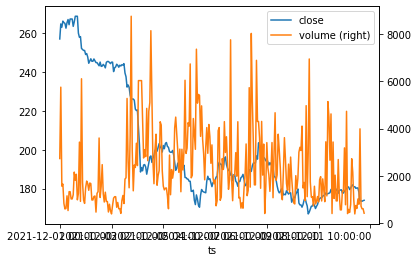

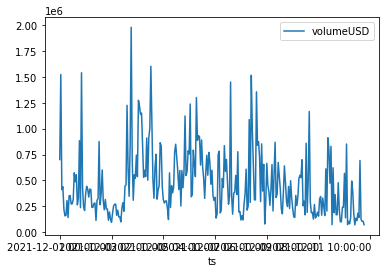

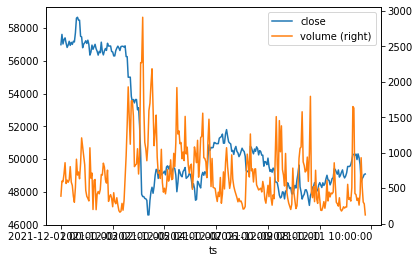

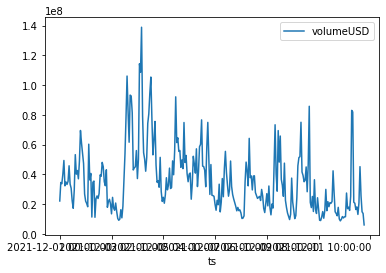

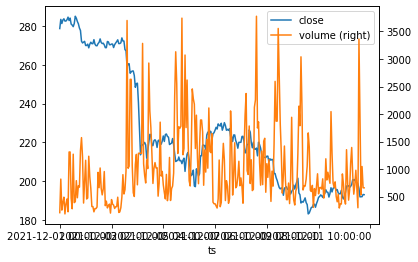

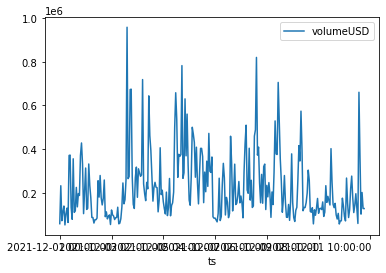

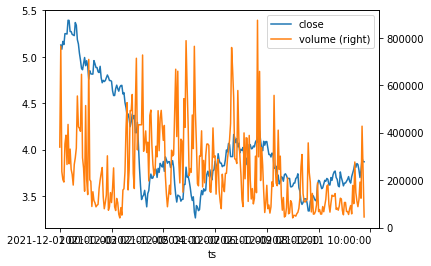

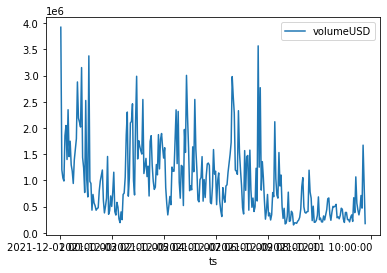

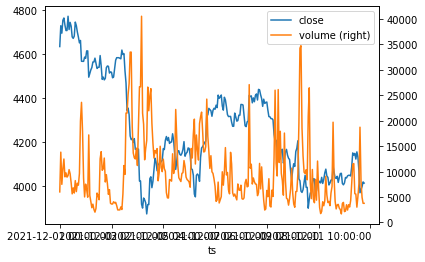

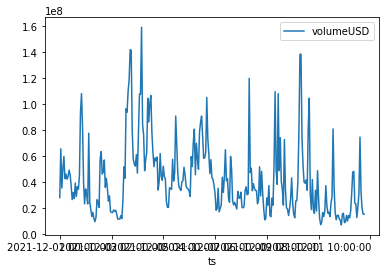

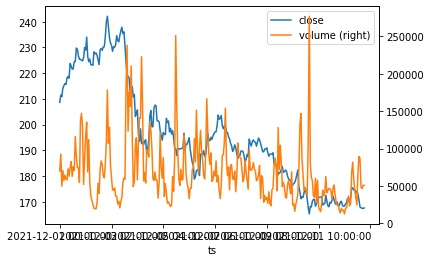

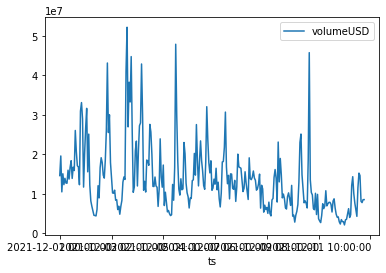

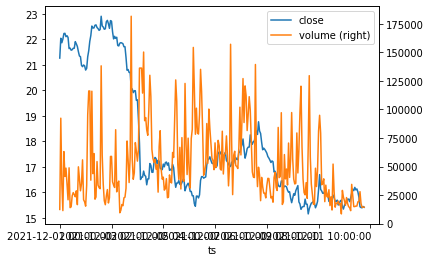

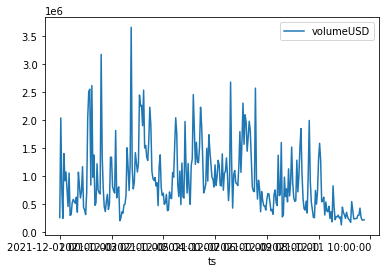

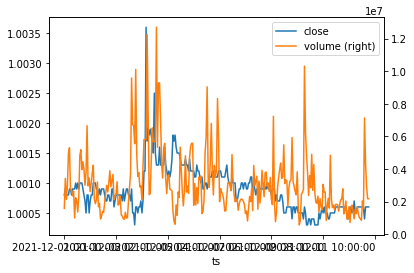

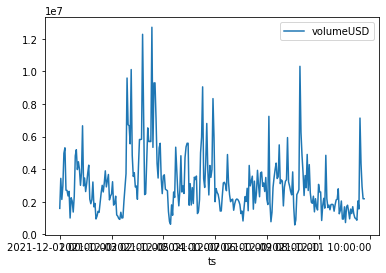

In [12]:
#take a look
for i in range(len(dfs)):  
    dfs[i][['close', 'volume']].plot(secondary_y='volume')
    dfs[i][['volumeUSD']].plot()

In [13]:
#calculate volumeUSD by chain
df1 = pd.concat(df for df in dfs)
df1.groupby(['chain', 'ts']).sum()['volumeUSD'].to_frame()

volumeUSD
chain ts                               
BTC   2021-12-01 00:00:00  2.213880e+07
      2021-12-01 01:00:00  3.455784e+07
      2021-12-01 02:00:00  3.374441e+07
      2021-12-01 03:00:00  4.026204e+07
      2021-12-01 04:00:00  4.934400e+07
...                                 ...
USDT  2021-12-13 02:00:00  7.136713e+06
      2021-12-13 03:00:00  4.340487e+06
      2021-12-13 04:00:00  2.930650e+06
      2021-12-13 05:00:00  2.180062e+06
      2021-12-13 06:00:00  2.180062e+06

[1180 rows x 1 columns]

In [14]:
df1.groupby(['chain']).sum()['volumeUSD'].to_frame()

,volumeUSD
chain,
BTC,1.056599e+10
ETH,1.318029e+10
SOL,4.006346e+09
USDT,9.178129e+08
